# C_4数据
导入需要使用的包并加载数据

In [1]:
import os
from collections import Counter
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import warnings

sns.set_style('darkgrid')
warnings.filterwarnings('ignore')

train = pd.read_csv('New folder/C_4_train.csv')
test = pd.read_csv('New folder/C_4_test.csv')
test['revenue'] = -1

df = pd.concat([train, test], axis=0, ignore_index=True)

## 数据洞察

### 字段整理

根据文件C_4_README.txt中对数据字段的描述，我们可以得到

|字段|描述|
|----|----|
|id|电影编号|
|belongs_to_collection|所属类别|
|budget|预算|
|genres|类型|
|homepage|主页 |
|imdb_id|imdb编号|
|original_language|语言|
|original_title|原标题|
|overview|概述|
|popularity|受欢迎度|
|poster_path|海报链接|
|production_companies|公司|
|production_countries|国家|
|release_date|发行日期|
|runtime|时长|
|spoken_languages|口语|
|status|状态|
|tagline|标语|
|title|标题|
|Keywords|关键词|
|cast|全体演员|
|crew|制作人员|
|revenue|收入|

其中revenue为我们需要预测的目标字段。

我们也可以简单看下数据的具体格式

In [2]:
df.head()

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,...,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue
0,1,"[{'id': 313576, 'name': 'Hot Tub Time Machine ...",14000000,"[{'id': 35, 'name': 'Comedy'}]",NaN,tt2637294,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",6.575393,...,2/20/15,93.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Laws of Space and Time are About to be Vio...,Hot Tub Time Machine 2,"[{'id': 4379, 'name': 'time travel'}, {'id': 9...","[{'cast_id': 4, 'character': 'Lou', 'credit_id...","[{'credit_id': '59ac067c92514107af02c8c8', 'de...",12314651
1,2,"[{'id': 107674, 'name': 'The Princess Diaries ...",40000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,tt0368933,en,The Princess Diaries 2: Royal Engagement,Mia Thermopolis is now a college graduate and ...,8.248895,...,8/6/04,113.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,It can take a lifetime to find true love; she'...,The Princess Diaries 2: Royal Engagement,"[{'id': 2505, 'name': 'coronation'}, {'id': 42...","[{'cast_id': 1, 'character': 'Mia Thermopolis'...","[{'credit_id': '52fe43fe9251416c7502563d', 'de...",95149435
2,3,NaN,3300000,"[{'id': 18, 'name': 'Drama'}]",http://sonyclassics.com/whiplash/,tt2582802,en,Whiplash,"Under the direction of a ruthless instructor, ...",64.299990,...,10/10/14,105.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The road to greatness can take you to the edge.,Whiplash,"[{'id': 1416, 'name': 'jazz'}, {'id': 1523, 'n...","[{'cast_id': 5, 'character': 'Andrew Neimann',...","[{'credit_id': '54d5356ec3a3683ba0000039', 'de...",13092000
3,4,NaN,1200000,"[{'id': 53, 'name': 'Thriller'}, {'id': 18, 'n...",http://kahaanithefilm.com/,tt1821480,hi,Kahaani,Vidya Bagchi (Vidya Balan) arrives in Kolkata ...,3.174936,...,3/9/12,122.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,NaN,Kahaani,"[{'id': 10092, 'name': 'mystery'}, {'id': 1054...","[{'cast_id': 1, 'character': 'Vidya Bagchi', '...","[{'credit_id': '52fe48779251416c9108d6eb', 'de...",16000000
4,5,NaN,0,"[{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...",NaN,tt1380152,ko,마린보이,Marine Boy is the story of a former national s...,1.148070,...,2/5/09,118.0,"[{'iso_639_1': 'ko', 'name': '한국어/조선말'}]",Released,NaN,Marine Boy,NaN,"[{'cast_id': 3, 'character': 'Chun-soo', 'cred...","[{'credit_id': '52fe464b9251416c75073b43', 'de...",3923970


### 特征筛选

根据问题的背景，我们需要对电影的收入进行预测，而数据集中有些字段并不是必要的，如数据的唯一id、在imdb上的编号，海报的链接等，显然这些数据特征不会对电影收入造成影响，我们应该予以剔除。

同时，对于数据缺失大于一半的严重缺失字段和数据高度相似没有差异的字段，都应予以剔除

In [3]:
missing_info = df.isna().mean().to_dict()
print( '字段缺失率：')
for key in missing_info:
    print(f'{key}: {round(missing_info[key] * 100, 2)}%')

字段缺失率：
id: 0.0%
belongs_to_collection: 79.98%
budget: 0.0%
genres: 0.31%
homepage: 68.02%
imdb_id: 0.0%
original_language: 0.0%
original_title: 0.0%
overview: 0.3%
popularity: 0.0%
poster_path: 0.03%
production_companies: 5.6%
production_countries: 2.12%
release_date: 0.01%
runtime: 0.08%
spoken_languages: 0.84%
status: 0.03%
tagline: 19.74%
title: 0.04%
Keywords: 9.04%
cast: 0.35%
crew: 0.51%
revenue: 0.0%


综上所述， 我们根据这些方法，选取了特征
- budget
- genres
- original_language
- popularity
- production_companies
- production_countries
- release_date
- runtime

## 数据处理
### budget
通过观察，预算特征的分布较广，是非常明显的长尾分布特征，因此我们对此取对数，变为近似正态分布的特征，满足统计学假设。

<AxesSubplot:xlabel='budget', ylabel='Count'>

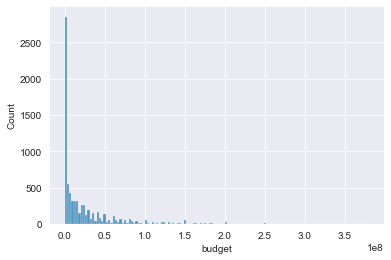

In [4]:
sns.histplot(df['budget'])

<AxesSubplot:xlabel='budget', ylabel='Count'>

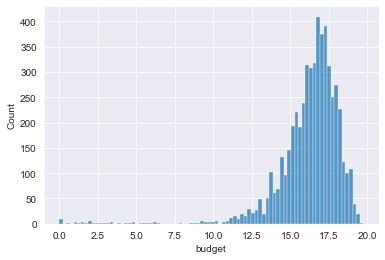

In [5]:
sns.histplot(np.log(df['budget']))

### genres

genres记录了电影所述的类别

In [6]:
df['genres'][:5]

0                       [{'id': 35, 'name': 'Comedy'}]
1    [{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...
2                        [{'id': 18, 'name': 'Drama'}]
3    [{'id': 53, 'name': 'Thriller'}, {'id': 18, 'n...
4    [{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...
Name: genres, dtype: object

共有 20 个电影类别，我们对此进行拆分，并将该变量进行One-Hot编码

In [7]:
genres_list= set()
for c in df['genres'].fillna('[]'):
    c = eval(c)
    for i in c:
        genres_list.add(i['name'])
genres_list

{'Action',
 'Adventure',
 'Animation',
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Family',
 'Fantasy',
 'Foreign',
 'History',
 'Horror',
 'Music',
 'Mystery',
 'Romance',
 'Science Fiction',
 'TV Movie',
 'Thriller',
 'War',
 'Western'}

In [8]:
genres_cols = []
for c in df['genres'].fillna('[]'):
    c = eval(c)
    genres_col = {key: 0 for key in genres_list}
    for name in c:
        genres_col[name['name']] = 1
    genres_cols.append(genres_col)
    
genres_cols = pd.DataFrame(genres_cols)
genres_cols.head()

,Action,Adventure,Animation,Comedy,Crime,Documentary,Drama,Family,Fantasy,Foreign,History,Horror,Music,Mystery,Romance,Science Fiction,TV Movie,Thriller,War,Western
0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,1,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0
2,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0
4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


### original_language

电影语言由于主要为英语，因此可作为二分类处理，为英语和非英语

英语 -> 1 非英语 -> 0

In [9]:
df['original_language'].value_counts()

en    6351
fr     199
hi     118
ru     109
es      95
ja      90
it      56
de      49
ko      49
zh      46
cn      41
ta      31
sv      20
da      17
pt      13
ml      12
nl      11
te       9
tr       9
ro       9
he       6
no       5
pl       5
th       5
fa       5
hu       4
fi       4
bn       3
id       3
sr       3
cs       3
el       3
bm       2
xx       2
ur       2
nb       1
ka       1
vi       1
ar       1
mr       1
ca       1
kn       1
af       1
is       1
Name: original_language, dtype: int64

In [10]:
df['original_language'].apply(lambda x: 1 if x == 'en' else 0).head()

0    1
1    1
2    1
3    0
4    0
Name: original_language, dtype: int64

### popularity

从图中可以看出，受欢迎程度与收入没有明显的相关关系，即使欢迎程度低也能取得不错的收入，但是受欢迎程度高的电影往往具有收入的下限

<AxesSubplot:xlabel='popularity', ylabel='revenue'>

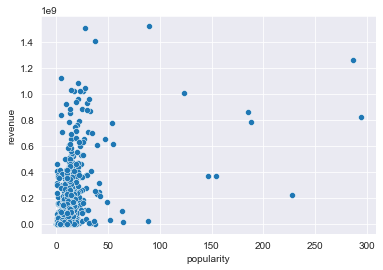

In [11]:
sns.scatterplot(x='popularity', y='revenue', data=train)

### production_companies

发行公司与电影种类的数据格式相同，但是由于公司的种类过多，不能使用相同的处理方式

因此我们转而统计每个公司发行电影的个数，发现大多数公司发行数量不超过5家，因此我们记发行数超过5家的为大公司，少于5家的为小公司。

In [12]:
company_list= []
for c in df['production_companies'].fillna('[]'):
    c = eval(c)
    for i in c:
        company_list.append(i['name'])
company_list = Counter(company_list)
pd.Series(company_list)

Paramount Pictures                                            393
United Artists                                                105
Metro-Goldwyn-Mayer (MGM)                                     207
Walt Disney Pictures                                          147
Bold Films                                                      8
Blumhouse Productions                                          32
Right of Way Films                                              5
Ghost House Pictures                                           11
North Box Productions                                           1
Jim Henson Productions                                          3
Jim Henson Company, The                                         6
Castle Rock Entertainment                                      44
Twentieth Century Fox Film Corporation                        341
Amercent Films                                                  7
American Entertainment Partners L.P.                            9
Interscope

In [13]:
company_kind = {key: 1 if company_list[key] > 5 else 0 for key in company_list}

(-0.5, 899.5, 599.5, -0.5)

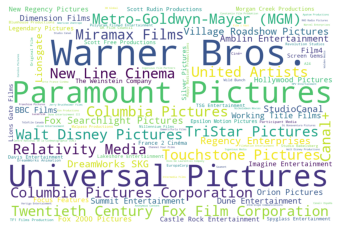

In [14]:
wd = WordCloud(background_color="white",repeat=True,max_words=100, height=600,width=900, random_state=42)
wd.generate_from_frequencies(company_list)
plt.imshow(wd)
plt.axis('off') 

### production_countries

国家可与公司采用同样的方法

In [15]:
country_list= []
for c in df['production_countries'].fillna('[]'):
    c = eval(c)
    for i in c:
        country_list.append(i['name'])
country_list = Counter(country_list)
pd.Series(country_list)

United States of America    5617
India                        220
South Korea                   58
Canada                       323
Serbia                         5
United Kingdom               917
Austria                       20
Germany                      411
France                       570
New Zealand                   37
Japan                        157
Ireland                       62
Italy                        160
Israel                        16
Belgium                       64
Czech Republic                30
China                         99
Brazil                        23
Argentina                     15
Chile                         10
Peru                           4
Hong Kong                     96
Russia                       132
Spain                        139
Turkey                        13
Australia                    148
Sweden                        50
Luxembourg                    19
South Africa                  24
Switzerland                   26
          

In [16]:
country_kind = {key: 1 if country_list[key] > 5 else 0 for key in country_list}

(-0.5, 899.5, 599.5, -0.5)

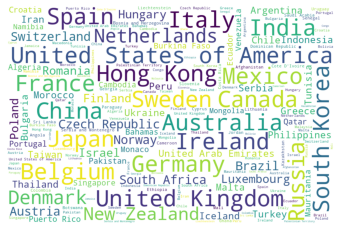

In [17]:
wd = WordCloud(background_color="white",repeat=True,max_words=100, height=600,width=900, random_state=42)
wd.generate_from_frequencies(country_list)
plt.imshow(wd)
plt.axis('off') 

### release_date

日期的格式较为复杂，由于年份只有最后两位，我们需要对此进行区分，并转换为日期格式

In [18]:
df['release_date'][:10]

0     2/20/15
1      8/6/04
2    10/10/14
3      3/9/12
4      2/5/09
5      8/6/87
6     8/30/12
7     1/15/04
8     2/16/96
9     4/16/03
Name: release_date, dtype: object

In [19]:
def convert_date(x):
    if type(x) == str:
        month, day, year = x.split('/')
        year = int(year)
        if year < 22:
            year = year + 2000
        else:
            year = year + 1900
        return f'{year}/{month}/{day}'
df['release_date'].apply(convert_date)[:10]

0     2015/2/20
1      2004/8/6
2    2014/10/10
3      2012/3/9
4      2009/2/5
5      1987/8/6
6     2012/8/30
7     2004/1/15
8     1996/2/16
9     2003/4/16
Name: release_date, dtype: object

### runtime

可以看出时长过长或过短的电影都没有较好的收入

我们按照收入阶梯观察时长

高收入电影分布在81-187分钟，我们以此对电影时长进行分桶

<AxesSubplot:xlabel='runtime', ylabel='revenue'>

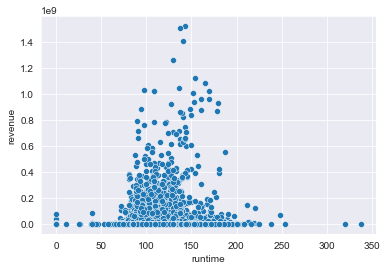

In [20]:
sns.scatterplot(x='runtime', y='revenue', data=df)

In [21]:
tmp_df = df[['runtime', 'revenue']].copy()
tmp_df['revenue_step'] = tmp_df['revenue'].apply(lambda x: 1 if x > 0.2e9 else 0)
tmp_df.groupby('revenue_step')['runtime'].describe()

,count,mean,std,min,25%,50%,75%,max
revenue_step,,,,,,,,
0,7133.0,107.326511,21.369872,0.0,94.0,104.0,117.0,338.0
1,259.0,118.478764,21.753075,81.0,102.0,117.0,131.5,187.0


In [22]:
pd.cut(df['runtime'], bins=[0, 87, 187, 999]).value_counts()

(87, 187]     6603
(0, 87]        724
(187, 999]      44
Name: runtime, dtype: int64

## 数据整合

In [23]:
use_cols = ['budget', 'genres', 'original_language', 'popularity', 'production_companies', 'production_countries', 'release_date', 'runtime']

data = pd.DataFrame()
# budget
data['budget'] = np.log(df['budget'] + 1)

# genres
data = pd.concat([data, genres_cols], axis=1)

# original_language
data['original_language'] = df['original_language'].apply(lambda x: 1 if x == 'en' else 0)

# popularity
data['popularity'] = df['popularity']

# production companies
data['production_companies'] = df['production_companies'].fillna('[]').apply(eval).apply(lambda x: max([company_kind[i['name']] for i in x]) if len(x)>0 else 0)

# production_countries
data['production_countries'] = df['production_countries'].fillna('[]').apply(eval).apply(lambda x: max([country_kind[i['name']] for i in x]) if len(x)>0 else 0)

# release date
data['release_date'] = pd.to_datetime(df['release_date'].apply(convert_date)).apply(lambda x: (datetime.datetime.now() - x).days / 365)

# runtime
data =pd.concat([data, pd.get_dummies(pd.cut(df['runtime'], bins=[0, 87, 187, 999]), prefix='runtime')], axis=1)

In [24]:
data.head(10)

,budget,Action,Adventure,Animation,Comedy,Crime,Documentary,Drama,Family,Fantasy,...,War,Western,original_language,popularity,production_companies,production_countries,release_date,"runtime_(0, 87]","runtime_(87, 187]","runtime_(187, 999]"
0,16.454568,0,0,0,1,0,0,0,0,0,...,0,0,1,6.575393,1,1,7.767123,0,1,0
1,17.504390,0,0,0,1,0,0,1,1,0,...,0,0,1,8.248895,1,1,18.315068,0,1,0
2,15.009433,0,0,0,0,0,0,1,0,0,...,0,0,1,64.299990,1,1,8.131507,0,1,0
3,13.997833,0,0,0,0,0,0,1,0,0,...,0,0,0,3.174936,0,1,10.720548,0,1,0
4,0.000000,1,0,0,0,0,0,0,0,0,...,0,0,0,1.148070,0,1,13.810959,0,1,0
5,15.894952,0,1,1,0,0,0,0,1,0,...,0,0,1,0.743274,0,0,35.328767,1,0,0
6,16.454568,0,0,0,0,0,0,0,0,0,...,0,0,1,7.286477,1,1,10.243836,0,1,0
7,0.000000,0,0,0,0,0,1,0,0,0,...,0,0,1,1.949044,0,0,18.873973,1,0,0
8,0.000000,1,1,0,1,0,0,0,1,0,...,0,0,1,6.902423,1,1,26.791781,0,1,0
9,15.607270,0,0,0,1,0,0,0,0,0,...,0,0,1,4.672036,1,1,19.624658,0,1,0


## 建立模型

In [25]:
from sklearn.linear_model import Lasso, Ridge, LinearRegression
from sklearn.neural_network import MLPRegressor

x = data.iloc[:train.shape[0], :]
y = np.log(train['revenue'])

### Lasso

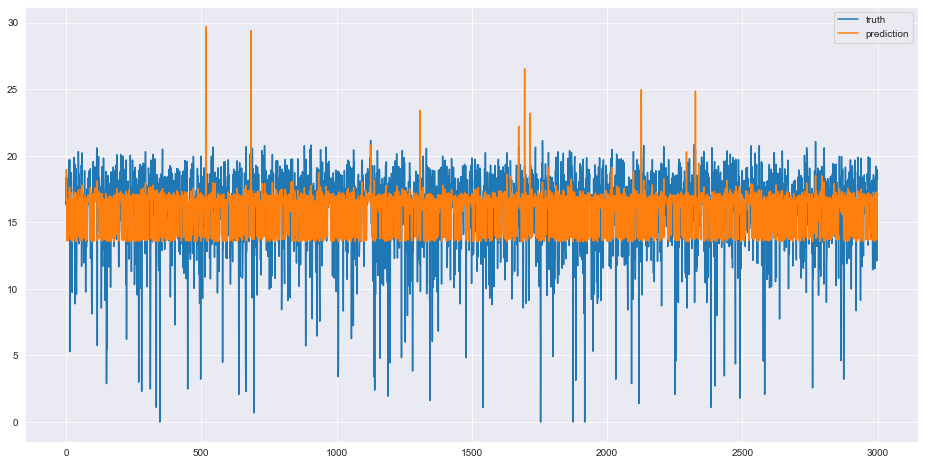

In [26]:
model = Lasso()
model.fit(x, y)
y_pred = model.predict(x)

plt.figure(figsize=(16, 8))
plt.plot(range(x.shape[0]), y, label='truth')
plt.plot(range(x.shape[0]), y_pred, label='prediction')
plt.legend()

### Ridge

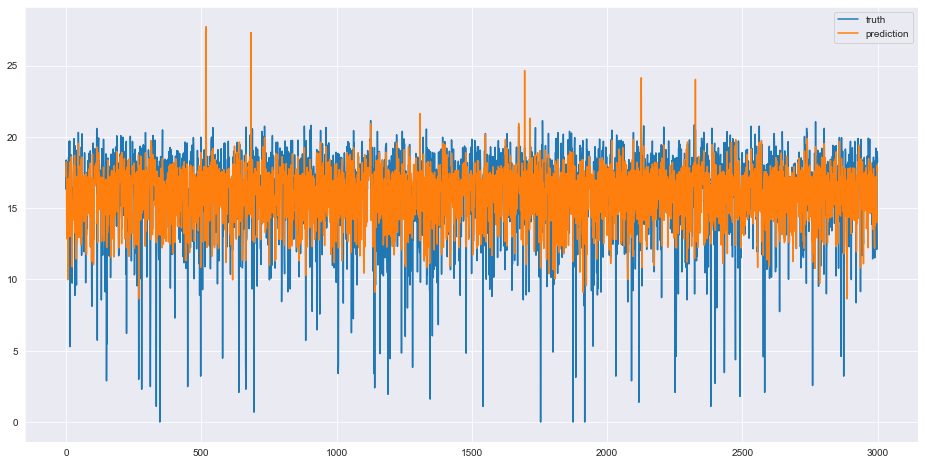

In [27]:
model = Ridge()
model.fit(x, y)
y_pred = model.predict(x)

plt.figure(figsize=(16, 8))
plt.plot(range(x.shape[0]), y, label='truth')
plt.plot(range(x.shape[0]), y_pred, label='prediction')
plt.legend()

### 多元统计回归

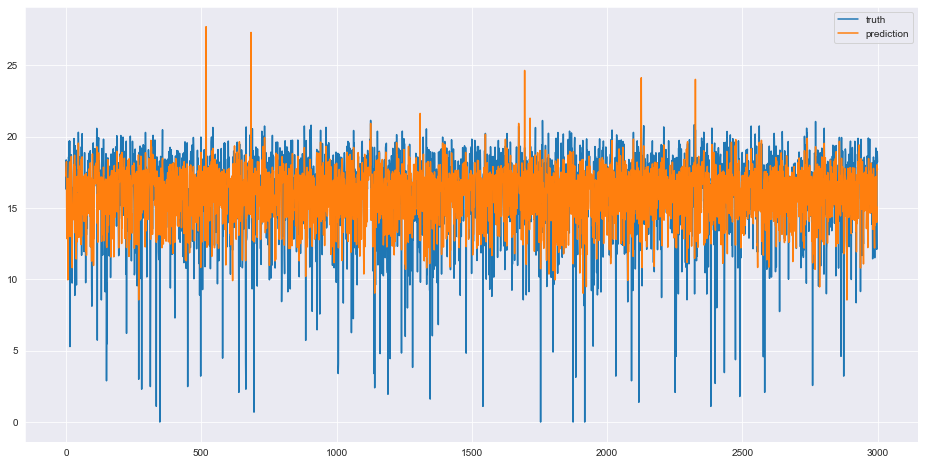

In [28]:
lr_model = LinearRegression()
lr_model.fit(x, y)
y_pred = lr_model.predict(x)

plt.figure(figsize=(16, 8))
plt.plot(range(x.shape[0]), y, label='truth')
plt.plot(range(x.shape[0]), y_pred, label='prediction')
plt.legend()

### BP神经网络

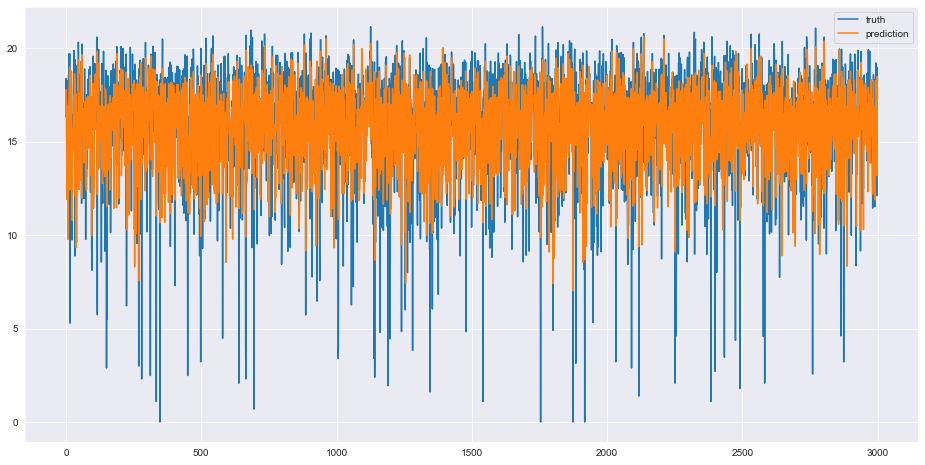

In [29]:
model = MLPRegressor()
model.fit(x, y)
y_pred = model.predict(x)

plt.figure(figsize=(16, 8))
plt.plot(range(x.shape[0]), y, label='truth')
plt.plot(range(x.shape[0]), y_pred, label='prediction')
plt.legend()

## 文字性结论

In [30]:
feature_importance = pd.DataFrame({'name': x.columns, 'importance': lr_model.coef_})

<AxesSubplot:xlabel='importance', ylabel='name'>

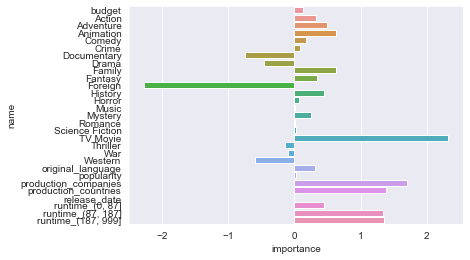

In [31]:
sns.barplot(y='name', x='importance', data=feature_importance)

能从图中看出，影响收入的主要因素是电影类型，其次是发行的公司、发行的城市以及电影的时长，能够得到主要结论有：
1. 类型为 Foreign 的电影会减少电影的收入，说明观众不喜欢看此类型的电影

2. 类型为TV_Movie的电影会显著增加电影的收入，说明观众非常喜欢观看此类电影

3. 发行公司越出名（发行电影数越多），电影的收入越高，能够形成品牌效应

4. 发行国家发行的电影数越多，电影的收入越多，说明电影受众多的国家发行电影能够吸引更多的观众票房

5. 电影的时长对电影的收入也有显著的影响，从图中可以看出，观众更喜欢时长较长的电影